In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import pickle as pk
from collections import defaultdict 
np.random.seed(2021)
import warnings
warnings.filterwarnings("ignore")

#### **Simplified version for blog post screen shot**

In [2]:
# # simplified code for blog post screenshots 
# # QL
# Q[s,a] = Q[s,a] + alpha*(reward - Q[s,a] 
#           + gamma*np.max([Q[s_,a_] for a_ in range(possible_action)]))

# # SARSA
# a_ = max_action(s_) if rand < (1-epsilon) else env.action_space.sample()
# Q[s,a] = Q[s,a] + alpha*(reward - Q[s,a] + gamma*Q[s_,a_])

#### **Quick demo of OpenAI Gym**

In [3]:
import gym  # OpenAI Gym
env = gym.make('CartPole-v0') # make environment

print("Number of action:", env.action_space.n)
print("State space configuration:", env.observation_space)

env.reset()   # reset environment

for _ in range(1000):
    # step: move, action_space.sample: move randomly
    env.step(env.action_space.sample()) # take a random action
env.close()

Number of action: 2
State space configuration: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


### **Cart pole game agent with 2 methods**

In [4]:
class CartPole():
  def __init__(self, boxes = (20, 20, 20, 20), set_bound = [4.8, 4.0, 0.4, 4.0]):
    '''
    Initialize the environment
    '''

    # env
    self.env = gym.make('CartPole-v0')

    # actions
    self.possible_action = self.env.action_space.n

    # discrete space
    self.boxes = boxes

    # The set bound here encorporates a little of knowledge into the system: 
    # As the variables have a huge range, here, I narrow the range a bit to 
    # limit the state space. If you don't want to incorperate the personal knowledge,
    # set set_bound = None
    if set_bound:
      set_bound = np.array(set_bound)
      self.high = set_bound
      self.low = -set_bound
    else:
      self.low = self.env.observation_space.low
      self.high = self.env.observation_space.high
      
    # set up discrete space values
    self.discrete_space = []
    for i in range(len(self.high)):
      self.discrete_space.append(np.linspace(self.low[i], self.high[i], self.boxes[i]))

    self.method = "QL"
    self.Q_table = defaultdict(lambda: defaultdict(int))

  def get_discrete(self, observation):
    '''
    Input the observed state and return its corresponding discrete state space
    tuple value because we will store it in the dictionary (list not hashable)
    '''
    
    new_state = []
    for i, val in enumerate(observation):
      new_state.append(int(np.digitize(val, self.discrete_space[i])))

    return tuple(new_state)

  def max_action(self, state):
    '''
    Input the state and return the best move at that state
    '''
    values = np.array([self.Q_table[self.method][state, action] for action in range(self.possible_action)])
    action = np.argmax(values)
    return action

  def train(self, method = "QL", num_games = 100001, alpha = 0.1,
               gamma = 0.9, epsilon = 1.0, temporary_game_check = 20000, plot_result = True):
    '''
    alpha: learning rate 
    gamma: discounted rate
    epsilon: exploration ratio
    temporary_game_check: print out results every "temporary_game_check" games
    num_games: number of trials
    '''

    # screening & initializing
    if method not in {"QL", "SARSA"}:
      raise ValueError("No such method! Try again!")

    self.method = method
    successful_steps = []

    for i in range(num_games):
      # printing to check process
      if i % temporary_game_check == 0:
        print('starting game', i)

      # foreach game, reset the environment      
      # cart x position, cart velocity, pole theta, pole velocity
      observation = self.env.reset()   
          
      s = self.get_discrete(observation[0])

      # e-greedy policy: epsilon chance of exploring and (1-epsilon) chance of exploiting 
      rand = np.random.random()
      a = self.max_action(s) if rand < (1 - epsilon) else self.env.action_space.sample()
      done = False

      succesful_step = 0

      # keep playing
      while not done:
        '''
        Move to the next state, use the next state value to update back the current state
        '''
        
        # Move to next state
        observation_, reward, done, info, _ = self.env.step(a)   
        s_ = self.get_discrete(observation_)

        # update (depends on learning method)
        if method == "QL":
            
          # off policy
          self.Q_table[method][s,a] = self.Q_table[method][s,a] + alpha*(reward + gamma*self.Q_table[method][s_, self.max_action(s_)] - self.Q_table[method][s,a])

          rand = np.random.random()
          a_ = self.max_action(s_) if rand < (1-epsilon) else self.env.action_space.sample()
        
        # TODO: Implement SARSA

        # update next state
        s, a = s_, a_    

        succesful_step += 1

      # epsilon decay every time so we explore less later in the game
      epsilon *= (num_games - 1)/num_games
      successful_steps.append(succesful_step)

    # save the Q table for further inference
    self.save(method = method, file_name = f"Q_table_{num_games}")

    # show results
    if plot_result:
      plt.figure(figsize=(12,8))
      plt.plot(successful_steps, 'b--')
      plt.xlabel("Games")
      plt.ylabel("Maximum steps")
      plt.title(f"Training result for {method} after {num_games} games")
      plt.show()
    
    return successful_steps

  def save(self, method = 'QL', file_name = 'Q_table'):
    '''
    Save Q_table to the pk file
    '''
    if method not in {"QL", "SARSA"}:
      raise ValueError("No such method! Try again!")
    
    with open(f'{file_name}_{method}.pk', 'wb') as handle:
      pk.dump(self.Q_table[method], handle, protocol=pk.HIGHEST_PROTOCOL)

  def play(self, method = None, model_dir = None, get_vid = True, print_result = True):
    '''
    Inference mode: choose the optimal path every time (as we want to play optimally)
    model_dir: if we want using pre-trained model
    get_vid: if you run this script in Python you can have a video of the agent playing
    (works with VS Code or command line, not on GG Colab)
    '''
    if method not in {"QL", "SARSA"}:
      method = self.method
      raise ValueError("No such method! Try again! Set to the most updated method used")

    # Get model (if there is)
    if model_dir:
      try:
        with open(model_dir, 'rb') as handle:
          self.Q_table[method] = pk.load(handle)
      except:
        print("Cannot find saved model. Use current model instead.")
    if method:
      self.method = method

    # inference: get observation play the best move and continue till terminate

    observation = self.env.reset()

    s = self.get_discrete(observation)
    rand = np.random.random()
    a = self.max_action(s)

    done = False
    succesful_step = 0

    while not done:
        if get_vid:
          try:
            self.env.render()
          except:
            get_vid = False
            print("Cannot render video. If you are using GG Colab, this function won't work!")
            print("Try VS Code or command line!")
        
        # choose the best action (and no update)
        succesful_step += 1
        observation_, reward, done, info, _ = self.env.step(a)   
        s_ = self.get_discrete(observation_)
        a_ = self.max_action(s_)
        s, a = s_, a_            
    if print_result:
      print(f"With {self.method}, the maximum steps I can play is: {succesful_step} steps!")
    self.env.close()   
    return succesful_step

  def play_performance(self, method = "QL", model_dir = None, trials = 1000, temp_check = 200):
    '''
    Simulate the performance of the agent with tons of games (as every game is random)
    '''

    # screening
    if method not in {"QL", "SARSA"}:
      method = self.method
      raise ValueError("No such method! Try again! Set to the most updated method used")

    # Get model (if there is)
    if model_dir:
      try:
        with open(model_dir, 'rb') as handle:
          self.Q_table[method] = pk.load(handle)
      except:
        print("Cannot find saved model. Use current model instead.")
    if method:
      self.method = method
    
    # simulate
    steps = []
    for i in range(trials):
      # print results once in a while
      if i % temp_check == (temp_check - 1):
        steps.append(QAgent.play(method=method, get_vid=False, print_result=True))
      else:
        steps.append(QAgent.play(method=method, get_vid=False, print_result=False))

    print("")
    print(f"The average (95% interval) I can play is {round(np.mean(steps), 2)} +- {round(2 * np.std(steps), 1)}")

    # plot
    plt.figure(figsize = (12, 8))
    plt.hist(steps)
    plt.xlabel("Successful steps")
    plt.ylabel("Number of games")
    plt.title(f"The result of the {method} agent with {trials} games")
    plt.show()

#### **Training**

In [5]:
QAgent = CartPole(boxes = (10, 10, 10, 10))

starting game 0
starting game 20000
starting game 40000
starting game 60000
starting game 80000
starting game 100000


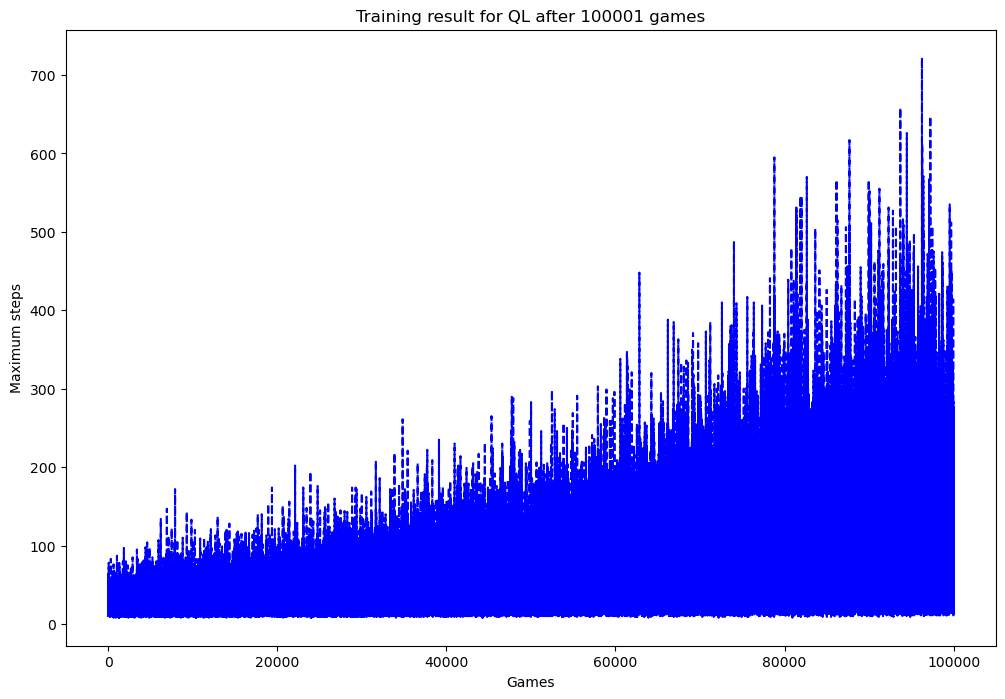

In [6]:
successful_steps = QAgent.train(method = "QL", num_games = 100001)

In [7]:
successful_steps = QAgent.train(method = "SARSA", num_games = 100001)

starting game 0


UnboundLocalError: local variable 'a_' referenced before assignment

#### **Inference**

In [ ]:
method = "QL"
QAgent.play_performance(method = method)

In [ ]:
method = "SARSA"
QAgent.play_performance(method = method)